Die Funktionsweise des entwickelten genetische Algorithmus wird hier schrittweise erläutert. Jedes Kapitel beschreibt das Vorgehen einer Funktion und zeigt es an einem praktischen Beispiel. Die Beispiele des Hauptteils von der Generierung einer Population bis zum Ende dieser Generation bauen aufeinander auf, sodass die Ergebnisse aus dem jeweilgien vorherigen Abschnitt übernommen werden.

Da der Algorithmus mit Zufallsvariablen arbeitet, wird ein Seed verwendet, um Ergebnisse nachvollziehbar reproduzieren zu können. Die Nummer für den Seed wird vor jedem Beispiel definiert und lässt sich ändern, um andere Verläufe zu generieren. Die in der Arbeit beschriebene Generation basiert auf der Population, welche mit der Seed-Nummer 3 generiert wird. Alle anschließenden Schritte folgen aus der Seed-Nummer 1.


# 1. Imports



Der Algorithmus verwendet verschiedene Bibliotheken. Zur Verarbeitung von Daten mit Arrays benutzt er NumPy, welches eine effiziente Manipulation von Datenstrukturen ermöglicht. Itertools ermöglicht es bei der Berechnung der Fitness-Werte die Iteration in manuell festgelegten Schritten festzulegen. Wenn Objekte kopiert werden und diese Kopie verändert wird, wird Copy verwendet, um das eigentliche Objekt nicht zu verändern. Pyplot dient zur Darstellung von Werten in Grafiken. Um die Integrität der Ergebnisse zu gewährleisten, wird die Funktion `exit()` von der Bibliothek Sys angewendet. Sobald die Werte der Population nicht mehr den Anforderungen des Algorithmuses entsprechen, beendet `exit()` den Durchlauf. Time dient zur Laufzeitmessung.

In [ ]:
import numpy as np
import itertools as it
import copy as cp
import matplotlib.pyplot as plt
import sys
import time

# 2. Initialisierung

Dieser Abschnitt erläutert die wesentlichen Variablen und Ausgangswerte.

In [ ]:
#  Werte, die verändert werden können
seed_number = 3
np.random.seed(seed_number)
selling_price = np.array([13, 9])  # Verkaufspreise der Produkte: P1 kostet 13, P2 9 Einheiten
supplier_price = np.array([[6, 4], [4, 3]])  # Lieferantenpreise der Produkte: [6, 4] bedeutet, dass P1 von L1 6 Einheiten kostet und P2 von L1 4 Einheiten kostet
transaction_cost = np.array([10, 30])  # Transaktionkosten der Lieferanten: L1 kostet 10, L2 30 Einheiten
holding_cost = np.array([30, 20])  # Lagerkosten für die Produkte: P1 kostet 30, P2 20 Einheiten
demands = np.array([30, 14])  # Nachfrage der Produkte: Nachfrage für P1 ist 30, für P2 14 Einheiten
number_products = len(selling_price)  # Anzahl an Produkten, abhängig von selling_price
number_suppliers = len(supplier_price)  # Anzahl an Lieferanten, abhängig von supplier_price
population_size = 3  # Populationsgröße
lower_bound = 0  # Untere Grenze für Werte zur Mutation
upper_bound = np.array([50, 34])  # Obere Grenze für Werte zur Mutation des jeweiligen Produktes: ein Gen von P1 kann bei der Mutation maximal den Wert 50 annehmen
number_iterations = 1  # Anzahl an Iterationen
number_generations = 15  # Anzahl an Generationen
penalty = 99999  # Strafe, wenn Chromosom nicht Anforderungen erfüllt

chromosome_size = number_suppliers * number_products  # Chromosomgröße
init_population = np.zeros((population_size, chromosome_size))  # Ausgangspopulation, zunächst nur aus Chromosomen mit 0 als Genen
number_parents = (population_size // 2) + (population_size % 2)  # Anzahl der Eltern, abhängig von der Populationsgröße
number_children = (population_size - number_parents)  # Anzahl der Nachfolgerm, abhängig von der Populationsgröße

#  Variablen zum Speichern und Analysieren
population_before = np.zeros((number_iterations, number_generations, population_size, chromosome_size))  # alle Populationen am Anfang einer Generation
population_fitness_before = np.zeros((number_iterations, number_generations, population_size))  # alle Fitness-Werte jeder Population am Anfang einer Generation
population_after = np.zeros((number_iterations, number_generations, population_size, chromosome_size))  # alle Populationen am Ende einer Generation
population_fitness_after = np.zeros((number_iterations, number_generations, population_size))  # alle Fitness-Werte jeder Population am Ende einer Generation
population_fitness_after_sum = np.zeros((number_iterations, number_generations))  # alle Summen der Fitness-Werte jeder Population am Ende einer Generation
best_chromosomes_after = np.zeros((number_iterations, number_generations, chromosome_size))  # alle besten Chromosome jeder Generation
best_fitness_after = np.zeros((number_iterations, number_generations))  # alle Fitness-Werte der besten Chromosome jeder Generation
best_chromosome_of_iteration = np.zeros((number_iterations, chromosome_size))  # besten Chromosome jeder Iteration
best_fitness_of_iteration = np.zeros(number_iterations)  # bester Fitness-Wert jeder Iteration

parents_list = np.zeros((number_iterations, number_generations, number_parents, chromosome_size))  # Liste aller Eltern
crossover_list = np.zeros((number_iterations, number_generations, number_children, chromosome_size))  # Liste aller Kreuzungen
tries_crossover_list = np.zeros((number_iterations, number_generations, number_children))  # Liste aller Versuchsanzahlen zur Kreuzung
mutation_list = np.zeros((number_iterations, number_generations, number_children, chromosome_size))  # Liste aller Mutationen
tries_mutation_list = np.zeros((number_iterations, number_generations, number_children))  # Lister aller Versuchsanzahlen zur Mutation

costs_list = np.zeros((number_iterations, number_generations, population_size, 4))  # Liste der einzelnen Kosten jeder Population
costs_max_list = np.zeros((number_iterations, number_generations, 4))  # Liste der einzelnen Kosten der besten Chromosome jeder Generation
costs_sum_list = np.zeros((number_iterations, number_generations, 4))  # Liste der Summe der Kosten jeder Generation


Produkte: | Produkt 1 | Produkt 2
--- | --- | --- 
Verkaufspreis: |   13 | 9
Lagerkosten: | 30 | 20
Nachfrage | 30 | 14


Kosten für jeden Lieferanten: | Produkt 1 | Produkt 2
--- | --- | ---
Lieferant 1 | 6 | 4
Lieferant 2 | 4 | 3

Transaktionskosten: | Lieferant 1 | Lieferant 2
--- | --- | ---
    | 10 | 30


# 3. Ausgangspopulation

## Funktionen

Die Funktion `random_population()` erzeugt eine zufällige Population aus `population_size` unterschiedlichen Chromosomen mit der Länge `chromosome_size`. Ausgehend von einer Population, die nur aus Chromosomen mit den Genen 0 besteht, erfolgt die Erstellung der einzelnen Chromosome nacheinander. Da ein Chromosom nur dann eine gültige Lösung darstellt, wenn die Nachfrage befriedigt wird, müssen die zufälligen Gene überprüft werden. Die Variable `sum_elements_product` speichert Summe der bestellten Menge eines Produkts. Ist diese Summe kleiner als die Nachfrage werden neue Werte solange generiert, bis das Chromosom die Bedingung für dieses Produkt erfüllt. Um gültige Produktmengen zu erzeugen, kann einem Gen ein zufälliger Wert von 0 bis zur Nachfrage zugeordnet werden. Mittels der Variable `product_index` erfolgt der Zugriff auf die für das Produkt relevante Stellen. Sind die Gene für ein Produkt zulässig, erhöht sich `product_index` um die Anzahl an Lieferanten und die Mengen für das nächste Produkt werden ermittelt. Anschließend wird das Chromosom in der Population gespeichert und das nächste Chromosom wird generiert. Die Methode gibt die Population zurück.

In [ ]:
def random_population():
    population_random = np.zeros(
        (population_size, chromosome_size))  # Ausgangspopulation, bestehend aus Chromosomen mit 0 als Gene
    for population_index in range(population_size):
        init_chromosome = np.zeros(chromosome_size)
        product_index = 0
        for product in range(number_products):  # Ermitteln der Werte für jedes Produkt
            # Die Summe der Produktmengen besteht aus dem Intervall von product_index bis product_index + number_suppliers
            sum_elements_product = sum(init_chromosome[product_index: product_index + number_suppliers])
            demand_product = demands[product]  # Nachfrage des entsprechenden Produkts
            while sum_elements_product < demand_product:  # Generierung neuer Werte solange die bestellte Menge kleiner als die Nachfrage ist
                for supplier in range(
                        number_suppliers):  # Jedes für das entsprechende Produkt relevante Gen erhält einen zufälligen Wert
                    init_chromosome[product_index + supplier] = np.random.randint(0, demand_product)
                sum_elements_product = sum(
                    init_chromosome[product_index: product_index + number_suppliers])  # Ermittlung der neuen Summe
            product_index += number_suppliers  # Erhöhung des Indexes um die Anzahl an Lieferanten, um das nächste Produkt zu bearbeiten
        population_random[population_index] = init_chromosome  # Speichern des Chromosoms
    return population_random

## Beispiel

Die in der Arbeit vorgestellte Population generiert der Algorithmus mit `seed_number` = 3.

In [ ]:
seed_number = 3
np.random.seed(seed_number)
example_population = random_population()
print(example_population)

[[10. 24.  8.  8.]
 [29. 19. 10. 11.]
 [25.  9. 10.  5.]]


# 4. Fitness-Wert

## Funktionen
Der Fitness-Wert eines Chromosoms ist abhängig von dem Verkaufspreis, dem Einkaufspreis, den Transaktionskosten und den Lagerkosten. Damit Chromosome mit negativen Fitness-Werten in der späteren Selektion nicht berücksichtigt werden, ordnet die Funktion ihnen den Fitness-Wert 0 zu.

In [ ]:
def calculate_fitness(chrom):
    sum_selling_price_demand = calculate_total_revenue()
    sum_supplier_price = calculate_purchase_cost(chrom)
    sum_transaction_cost = calculate_transaction_cost(chrom)
    sum_holding_cost = calculate_holding_cost(chrom)
    fitness = sum_selling_price_demand - sum_supplier_price - sum_transaction_cost - sum_holding_cost
    #  Die Roulette Wheel Selection verhindert das Auswählen von Chromosomen, deren Fitness 0 ist.
    if fitness < 0:
        fitness = 0
    return fitness

Die Funktion `calculate_total_revenue()` berechnet den totalen Umsatz aller Produkte. Der Umsatz eines Produktes ergibt sich aus der Multiplikation von Nachfrage (`demands[product]`) und Verkaufspreis (`selling_price[product]`). Die Summe aller Umsätze wird in der Variable `revenue` gespeichert und zurückgegeben.

In [ ]:
def calculate_total_revenue():
    revenue = 0
    for product in range(number_products):
        # Dem bisherigen Umsatz wird der Umsatz dieses Produktes hinzugefügt
        revenue += (demands[product] * selling_price[product])  
    return revenue

Die `calculate_purchase_cost(chrom)` Funktion definiert die Einkaufskosten eines Chromosoms. Für jedes Produkt werden die Kosten durch die Multiplikation der Menge mit dem Lieferantenpreis ermittelt. Die Summe daraus ergibt daraus die Einkaufskosten insgesamt.

In [ ]:
def calculate_purchase_cost(chrom):
    product_index = 0
    purchase = 0
    for product in range(number_products):
        for supplier in range(number_suppliers):
            # Den bisherigen Kosten werden die Kosten von einem Lieferanten hinzugefügt
            purchase += chrom[product_index] * supplier_price[supplier][product]
            product_index += 1
    return purchase

Die Transaktionskosten eines Chromosoms werden durch die Funktion `calculate_transaction_cost(chrom)` bestimmt. Transaktionskosten treten auf, von einem Lieferanten mindestens ein Produkt bezogen wird. Die Kosten sind also unabhängig davon, ob ein oder mehrere Produkte bestellt werden. Hier überprüft die Methode nun alle Lieferanten nacheinander. Mittels der Funktion `islice()` ermittelt der Algorithmus die insgesamt bestellte Menge bei einem Lieferanten. Ist diese größer als 0, treten die einmaligen Transaktionskosten des jeweiligen Lieferanten auf. Die Summe dieser Kosten wird als `transaction` zurückgegeben.

In [ ]:
def calculate_transaction_cost(chrom):
    transaction = 0
    for supplier in range(number_suppliers):
        # Die Summe wird im Bereich von supplier bis chromosome_size in Schritten der Größe number_suppliers ermittelt
        sum_supplier_product = sum(it.islice(chrom, supplier, chromosome_size, number_suppliers))  
        if sum_supplier_product != 0:
            transaction += transaction_cost[supplier]
    return transaction

Lagerkosten treten für Produkte auf, die nicht verkauft wurden und im Lager vorrätig bleiben. Die Funktion `calculate_holding_cost(chrom)` bestimmt für jedes Produkt die übrige Menge `remaining_quantity_product` und leitet daraus die Lagerkosten `sum_holding_cost` her. Gleichzeitig überprüft die Funktion die Bedingung, ob die Nachfrage gedeckt wird. Ist `remaining_quantity_product` negativ, sind weniger Produkte vorhanden als notwendig. Die Funktion gibt den Wert von `penalty` zurück. Ist dies nicht der Fall erhöht sich `sum_holding_cost` um die Lagerkosten des Produkts.

In [ ]:
def calculate_holding_cost(chrom):
    sum_holding_cost = 0
    product_index = 0
    for product in range(number_products):
        #  Menge eines Produktes besteht aus der Summe des Intervalls von product_index bis product_index + number_suppliers
        quantity_product = np.sum(chrom[product_index:product_index + number_suppliers])
        #  Differenz aus vorhandener Produktmenge und Nachfrage des Produkts
        remaining_quantity_product = quantity_product - demands[product]
        #  Übrigen Produktmengen multipliziert mit den Lagerkosten des entsprechenden Produktes
        remaining_holding_cost = remaining_quantity_product * holding_cost[product]
        #  Erhöhen des Indexes für das nächste Produkt
        product_index += number_suppliers
        #  Sind die Lagerkosten negativ, ist die Bestellmenge kleiner als die Nachfrage und die Lösung nicht zulässig
        if remaining_holding_cost < 0:
            return penalty
        else:
            sum_holding_cost += remaining_holding_cost
    return sum_holding_cost

## Beispiel

Der Fitness-Wert des Chromosoms $[25, 9, 10, 5]$ ist 95. Der Umsatz des ist abhängig von der Nachfrage und dem Verkaufsspreis. Er ergibt sich aus folgenden Gleichungen.

Die Berechnung beginnt mit der Ermittlung des Umsatzes. Dieser ist konstant für alle Chromosome und berechnet sich wie folgt:

$ TU = 13 * 30 + 9 * 14 = 516 $

Im zweiten Schritt wird der Einkaufspreis festgestellt. Der Algorithmus geht
hier produktweise vor.

$ EP_{1} = 25 * 6 + 9 * 4 = 186 $

$ EP_{2} = 10 * 4 + 5 * 3 = 55 $

$ EP = EP_{1} + EP_{2} = 186 + 55 = 241 $

Die Transaktionskosten werden hingegen lieferantenweise bestimmt. Alle Gene,
die in Verbindung mit einem Lieferanten stehen, haben einen Abstand von der
Lieferantenanzahl. Für $L_{1}$ sind die Gene 25 und 10 relevant. Die Summe ist
größer als 0, sodass einmalige Transaktionskosten anfallen. Die Menge, die der
Händler von Lieferant $L_{2}$ bezieht, ist 14. Die Transaktionskosten lauten nun wie
folgt:

$ TK = 10 + 30 = 40 $

Den letzten Faktor bilden die Lagerkosten. Das Verfahren erfolgt produktweise,
da die gesamte Menge eines Produkts relevant ist. Aus der Differenz dieser Menge und der Nachfrage entsteht die überschüssige Menge. Multipliziert man
die Differenz mit dem Kostensatz, kommt man auf die Lagerkosten. Für die
Produkte $P_{1}$ und $P_{2}$ gelten folgende Lagerkosten.

$ LK_{1} = ((25 + 9) - 30) * 30 = 120 $

$ LK_{2} = ((10 + 5) - 14) * 20 =  20 $

$ LK = 120 + 20 = 140 $

Ein Chromosom, das die Nachfrage nicht bedienen kann, besitzt negative Lagerkosten. Das Chromosom $C_{BSP} = [25, 9, 3, 5]$ kann die Nachfrage für Produkt $P_{2}$ nicht erfüllen. In diesem Fall ordnet der GA dem Chromosom Lagerkosten von 99999 zu, sodass der Fitness-Wert garantiert negativ ist.

$ LK_{BSP2} = ((2 + 5) − 14) ∗ 20 = −140 < 0 ⇒ LK = 99999 $

Die Differenz der einzelnen Kosten bildet den Gewinn.

$ \pi = TU - (EP + TK + LK) = 516 - 241 - 40 - 140 = 95 $

Um in der späteren Selektion nur Chromosome mit positiven Werten zu berücksichtigen, werden alle Fitness-Werte, die kleiner als 0 sind, auf 0 gesetzt. Dies ist bei Chromosom $C_{2}$ der Fall.

$ \pi_{C2} = 516 − 323 − 40 − 680 = −527 < 0 ⇒ π = 0$

In [ ]:
seed_number = 3
np.random.seed(seed_number)
example_population = random_population()
print(example_population)
for solution in example_population:
    print ("Fitness of chromosome", solution, "=", calculate_fitness(solution))

[[10. 24.  8.  8.]
 [29. 19. 10. 11.]
 [25.  9. 10.  5.]]
Fitness of chromosome [10. 24.  8.  8.] = 104.0
Fitness of chromosome [29. 19. 10. 11.] = 0
Fitness of chromosome [25.  9. 10.  5.] = 95.0


# 5. Selektion

## Funktionen

Die Funktion `select_parents(fitness, number, pop)` wählt `number_parents` Chromosome als Eltern aus. Die Selektion ist abhängig von den Fitness-Werten, sodass Chromosome mit einem hohen Fitness-Werte eine höhere Warscheinlichkeit zur Auswahl besitzen. Die merfache Auswahl eines Chromosoms ist nur dann möglich, wenn nicht ausreichend viele Chromosome mit positiven Fitness-Werten vorhanden sind. In diesem Fall wählt der Algorithmus das erstgewählte Chromosom erneut aus. Daraus folgt, dass mindestens eine Lösung mit positiven Ergebnissen existieren muss. Ist dies nicht der Fall stoppt der Algorithmus.

Die Methode benötigt eine Liste mit Fitness-Werten `fitness`, eine Anzahl an Eltern `number` und eine Population `pop`. Ausgehend von den übergebenen Parametern überprüft die Funktion zunächst, ob ein Chromosom mit positivem Fitness-Wert vorhanden ist. Anschließend erzeugt er eine leere Population `parents_new` und erzeugt `number` Eltern. Hier wird die Funktion `select_parents_roulette()` aufgerufen, welche ein Chromosom als Elternteil auswählt. Das Chromosom wird aus `pop` und `fitness` entfernt, damit es nicht erneut ausgewählt werden kann.

In [ ]:
def select_parents(fitness, number, pop):
    #  Überprüfen, ob positive Chromosome vorhanden sind
    if sum(fitness) == 0:
        print("No positive values")
        sys.exit()

    parents_new = np.empty((number, chromosome_size), dtype=int)
    #  Auswählen von number Eltern
    for parent_counter in range(0, number):
        #  Wenn kein positives Chromosom vorhanden ist, wird das erstgewählte Chromosom kopiert
        #  Durch die vorherige Überprüfung ist dies erst nach der erfolgreichen Selektion eines Chromosoms möglich
        if np.sum(fitness) == 0:
            parents_new[parent_counter] = parents_new[0]
        else:
            #  Auswählen eines Chromosoms durch die Roulette Wheel Selection
            parents_new[parent_counter] = select_parents_roulette(fitness, pop)
            #  Hilfsfunktion zum Ermitteln des Indexes eines Chromosoms in der Population
            index_delete_element = delete_element_from_lists(pop, parents_new[parent_counter])
            #  Entfernen des Chromosoms aus der Fitness-Liste und der Population
            pop = np.delete(pop, index_delete_element, axis=0)
            fitness = np.delete(fitness, index_delete_element, axis=0)
    return parents_new

Die Funktion `delete_element_from_lists(pop, element)` dient als Hilfsfunktion und gibt den Index eines Chromosoms aus. Wird dieses Element nicht gefunden, stoppt der Algorithmus.

In [ ]:
def delete_element_from_lists(pop, element):
    #  Überprüft schrittweise, ob ein Element dem gesuchten Element entspricht
    for pos in range(len(pop)):
        check = np.equal(pop[pos], element)
        #  Wurde das Element gefunden, gibt die Methode den Index zurück
        if np.all(check == True):
            index_delete_element = pos
            return index_delete_element
    print("Delete not successfull")
    sys.exit()

Die Funktion `select_parents_roulette(fitness, pop)` gibt den Index eines Elementes aus, welches durch die Roulette Wheel Selection ausgewählt wurde. In dieser Methode werden alle Fitness-Werte summiert und bilden jeweils Intervalle. Eine zufällige Zahl zwischen 0 und der Summe ermittelt das ausgewählte Chromosom.

Mittels der Fitness-Liste `fitness` und der Population `pop` ermittelt die Funktion die Summe der Fitness-Werte. Ist diese Summe 0, bricht der Algorithmus ab. Anschließend generiert die Methode eine zufällige Zahl `selector` und überprüft, in welchem Intervall diese Zahl liegt. In der while-Schleife geht der Algorithmus jedes Intervall solange durch, bis das Intervall gefunden wurde.

In [ ]:
def select_parents_roulette(fitness, pop):
    #  Überprüfen, ob positive Chromosome vorhanden sind
    sum_fitness = np.sum(fitness)
    if sum_fitness == 0:
        print("No sum of fitness")
        sys.exit()

    #  Zahl zum Auswählen des Chromosoms
    selector = np.random.randint(1, sum_fitness)
    print("Find interval of", selector)
    find_interval = False
    sum_elements = 0
    counter = 0
    #  liegt die Zahl zwischen 0 und dem ersten Fitness-Wert, wird das entsprechende Chromosom ausgewählt.
    #  Wenn nicht addiert die Methode zum ersten Fitness-Wert den nächsten Fitness-Wert und überprüft, ob die Zahl kleiner als diese Summe ist.
    #  Dieser Prozess wiederholt sich solange, bis das Chromosom gefunden wurde.
    while not find_interval:
        if selector <= sum_elements + fitness[counter]:
            find_interval = True
        else:
            sum_elements += fitness[counter]
            counter += 1
    return pop[counter]

## Beispiel

In [ ]:
#  Population
seed_number = 3
np.random.seed(seed_number)
example_population = random_population()

example_fitness_list = np.array([0, 0, 0])
example_counter = 0
for example_chromosome in example_population:
    example_fitness_list[example_counter] = calculate_fitness(example_chromosome)
    example_counter += 1

print ("Example population:", example_population)
print ("Example fitness:", example_fitness_list)

#  Eltern
seed_number = 1
np.random.seed(seed_number)
example_parents = select_parents(example_fitness_list, number_parents, example_population)
print ("Select", number_parents, "parents.","Example parents:", example_parents)

Example population: [[10. 24.  8.  8.]
 [29. 19. 10. 11.]
 [25.  9. 10.  5.]]
Example fitness: [104   0  95]
Find interval of 38
Find interval of 13
Select 2 parents. Example parents: [[10 24  8  8]
 [25  9 10  5]]


# 6. Crossover

## Funktionen

Die Funktion `cross_parents_uniform(cross_parents, boundary_iterations, gen, iteration)` erstellt neue Chromosome durch das Kreuzen von zwei Eltern. Jedes Gen der Eltern wird mit einer Wahrscheinlichkeit von 50% übernommen. Die Eltern werden solange gekreuzt, bis die Fitness des Nachfolgers positiv ist. Der Nachfolger kann vollständig einem Elternteil entsprechen. Die Kreuzung unterscheidet sich abhängig von der größe der Population. Ist die Größe ungerade, kreuzen sich die Elternteile nacheinander. Ist die Größe gerade, kreuzen sich zusätlich das letzte und das erste Elternteil.

`cross_parents_uniform` arbeitet mit den Eltern `cross_parents`, einer Abbruchbedingung `boundary_iterations`, der akuellen Generation `gen` und der entsprechenden Iteration `iteration`.

In [ ]:
def cross_parents_uniform(cross_parents, boundary_iterations, gen, iteration):
    crossover_children = np.empty((number_children, chromosome_size), dtype=int)
    # Erstellen von number_children Nachfolgern
    for index in range(number_children):
        child = np.full(chromosome_size, 0)
        limit = 0
        #  Kreuzen der Eltern solange der Nachfolger negativ ist und die maximale Anzahl an Versuchen nicht erreicht wurde
        while calculate_fitness(child) <= 0 and limit < boundary_iterations:
            #  Der erste Fall tritt ein, wenn die Anzahl der Eltern ungerade ist.
            #  Der zweite Fall tritt ein, wenn die Anzahl der Eltern gerade ist und der Index dem letzten Elterteil entspricht.
            if index != len(cross_parents) - 1:
                first_parent = cross_parents[index]
                second_parent = cross_parents[index + 1]
            else:
                first_parent = cross_parents[index]
                second_parent = cross_parents[0]
            #  Generieren der Gene des Nachfolgers
            for each_number in range(len(child)):
                #  Zufällige Variable p ist entweder 0 oder 1.
                #  Ist p = 0, wird das Gen des ersten Elternteils übernommen.
                p = np.random.randint(0, 2)
                if p < 0.5:
                    child[each_number] = first_parent[each_number]
                else:
                    child[each_number] = second_parent[each_number]
            #  Das Gen wird dem Chromosom an der Stelle index zugeordnet
            crossover_children[index] = child
            limit += 1

            #  Wird die maximale Anzahl an Versuchen erreicht, wird ein Elternteil vollständig kopiert
            if limit == boundary_iterations:
                random_choice = np.random.randint(0, 2)
                crossover_children[index] = cp.copy(cross_parents[index + random_choice])
        tries_crossover_list[iteration][gen][index] = limit
    return crossover_children

## Beispiel

In [ ]:
#  Population
seed_number = 3
np.random.seed(seed_number)
example_population = random_population()

example_fitness_list = np.array([0, 0, 0])
example_counter = 0
for example_chromosome in example_population:
    example_fitness_list[example_counter] = calculate_fitness(example_chromosome)
    example_counter += 1

print("Example population:", example_population)
print("Example fitness:", example_fitness_list)

#  Eltern
seed_number = 1
np.random.seed(seed_number)
example_parents = select_parents(example_fitness_list, number_parents, example_population)
print ("Select", number_parents, "parents.","Example parents:", example_parents)

#  Kreuzung
example_crossover = cross_parents_uniform(example_parents, 100, 0, 0)
print("Parents:", example_parents)
for crossed in example_crossover:
  print("Crossover:", crossed)

Example population: [[10. 24.  8.  8.]
 [29. 19. 10. 11.]
 [25.  9. 10.  5.]]
Example fitness: [104   0  95]
Find interval of 38
Find interval of 13
Select 2 parents. Example parents: [[10 24  8  8]
 [25  9 10  5]]
Parents: [[10 24  8  8]
 [25  9 10  5]]
Crossover: [25  9  8  8]


# 7. Mutation

## Funktionen

Die Funktion `mutate_crossover(cross, boundary_iterations, gen, iteration)` mutiert Chromosome solange, bis deren Fitness größer als vorher ist. Bei der Mutation wird ein beliebiges Gen durch eine zufällige Zahl ausgetauscht. Die zufällige Zahl ist dabei abhängig vom betroffenem Produkt. Zunächst sucht der Algorithmus ein zufälliges Produkt aus. Ausgehend vom Produkt wird ein zufälliges Gen ausgewählt und mutiert. Um unnötig hohe Werte zu vermeiden, ist die obere Grenze für jedes Produkt die Nachfrage plus 20. Findet der Algorithmus nach `boundary_iterations` keine bessere Mutation, wird die Kreuzung nicht verändert. 

In [ ]:
def mutate_crossover(cross, boundary_iterations, gen, iteration):
    mutation_crossover = np.empty((len(cross), chromosome_size), dtype=int)
    #  Mutieren von jedem Nachfolger
    for index in range(len(cross)):
        fit = calculate_fitness(cross[index])
        child = np.full(chromosome_size, 0)
        limit = 0
        #  Mutieren solange Fitness kleiner als vorher ist und die maximale Anzahl an Versuchen nicht erreicht ist
        while calculate_fitness(child) <= fit and limit < boundary_iterations:
            child = cp.copy(cross[index])
            #  Zufällige Zahl entscheidet, welches Produkt mutiert wird
            random_product = np.random.randint(0, number_products)
            #  Index der ersten Stelle des Produktes
            first_element = random_product * number_suppliers
            #  Indexes der Gene des Produktes
            list_element_indexes = np.arange(first_element, first_element + number_suppliers)
            #  Auswahl eines zufälligen Indexes des ausgewählten Produktes
            random_position = np.random.choice(list_element_indexes, 1, False)
            #  Mutation dieser Stelle durch eine zufällige Zahl zwischen 0 und der entsprechenden Grenze
            number_mutation = np.random.randint(lower_bound, upper_bound[random_product])
            child[random_position] = number_mutation
            limit += 1

            if limit == boundary_iterations:
                child = cp.copy(cross[index])
        tries_mutation_list[iteration][gen][index] = limit
        mutation_crossover[index] = cp.copy(child)
        print("tries",tries_mutation_list[iteration][gen][index])
    return mutation_crossover

## Beispiel

In [ ]:
#  Population
seed_number = 3
np.random.seed(seed_number)
example_population = random_population()

example_fitness_list = np.array([0, 0, 0])
example_counter = 0
for example_chromosome in example_population:
    example_fitness_list[example_counter] = calculate_fitness(example_chromosome)
    example_counter += 1

print("Example population:", example_population)
print("Example fitness:", example_fitness_list)

#  Eltern
seed_number = 1
np.random.seed(seed_number)
example_parents = select_parents(example_fitness_list, number_parents, example_population)
print ("Select", number_parents, "parents.","Example parents:", example_parents)

#  Kreuzung
example_crossover = cross_parents_uniform(example_parents, 100, 0, 0)
print("Parents:", example_parents)
for crossed in example_crossover:
    print("Crossover:", crossed)

#  Mutation
example_mutation = mutate_crossover(example_crossover, 1000, 0, 0)
for mutated in example_mutation:
    print("Mutation:", mutated)

Example population: [[10. 24.  8.  8.]
 [29. 19. 10. 11.]
 [25.  9. 10.  5.]]
Example fitness: [104   0  95]
Find interval of 38
Find interval of 13
Select 2 parents. Example parents: [[10 24  8  8]
 [25  9 10  5]]
Parents: [[10 24  8  8]
 [25  9 10  5]]
Crossover: [25  9  8  8]
tries 1.0
Mutation: [25  9  8  7]


# 8. Population

## Funktionen

Die Funktion `update_population(par, cross)` generiert eine neue Population, basierend auf den übergebenen Eltern `par` und den Nachfolgern `cross`.

In [ ]:
def update_population(par, cross):
    population_update = np.concatenate((par, cross))
    return population_update

## Beispiel

In [ ]:
#  Population
seed_number = 3
np.random.seed(seed_number)
example_population = random_population()

example_fitness_list = np.array([0, 0, 0])
example_counter = 0
for example_chromosome in example_population:
    example_fitness_list[example_counter] = calculate_fitness(example_chromosome)
    example_counter += 1

print("Example population:", example_population)
print("Example fitness:", example_fitness_list)

#  Eltern
seed_number = 1
np.random.seed(seed_number)
example_parents = select_parents(example_fitness_list, number_parents, example_population)
print ("Select", number_parents, "parents.","Example parents:", example_parents)

#  Kreuzung
example_crossover = cross_parents_uniform(example_parents, 100, 0, 0)
print("Parents:", example_parents)
for crossed in example_crossover:
    print("Crossover:", crossed)

#  Mutation
example_mutation = mutate_crossover(example_crossover, 1000, 0, 0)
for mutated in example_mutation:
    print("Mutation:", mutated)

#  Neue Population
example_population_updated = update_population(example_parents, example_mutation)
print("New population:", example_population_updated)

Example population: [[10. 24.  8.  8.]
 [29. 19. 10. 11.]
 [25.  9. 10.  5.]]
Example fitness: [104   0  95]
Find interval of 38
Find interval of 13
Select 2 parents. Example parents: [[10 24  8  8]
 [25  9 10  5]]
Parents: [[10 24  8  8]
 [25  9 10  5]]
Crossover: [25  9  8  8]
tries 1.0
Mutation: [25  9  8  7]
New population: [[10 24  8  8]
 [25  9 10  5]
 [25  9  8  7]]


# 9. Algorithmus

## Funktionen

Die Funktion `main_part(gen, pop, different_population)` fügt alle beschriebenen Kapitel zusammen und repräsentiert den genetischen Algorithmus. Die einzelnen Schritte und deren Teilschritte sind nummeriert und im Code entsprechend markiert.

Der Algorithmus folgt diesen Schritten:

1.   Generieren einer zufälligen Population

Fall 1a tritt ein, wenn bereits eine Generation berechnet wurde und die End-Population für die nächste Generation als Ausgangspopulation ausgewählt wird. Der Fall 1b tritt bei der ersten Generation einer Iteration ein.

2.   Berechnen der Fitness-Werte der aktuellen Generation

Der Algorithmus berechnet die Fitness-Werte und überprüft bei 2a, ob die Population Chromosome mit positiven Fitness-Werten enthält. Liegt dies nicht vor, wird solange eine neue zufällige Population generiert, bis die Bedingung erfüllt wird. Dieser Fall ist am Anfang einer Iteration relevant.

3.   Selektion der Eltern
4.   Kreuzung der Eltern
5.   Mutation der Kreuzungen
6.   Zusammenfügen der Eltern und der Nachfolger
7.   Berechnen der Fitness-Werte der neuen Generation
8.   Speichern von relevanten Daten zur Darstellung derer Verläufe

Zu diesen Daten gehören die Kosten eines Chromosoms (8a), die Summe der Kosten einer Generation (8b), die Summe der Fitness-Werte einer Generation (8c), das beste Chromosom einer Generation (8d), die Kosten des besten Chromosoms einer Generation (8e) und das beste Chromosom einer Iteration (8f).

In [ ]:
def main_part(gen, pop, different_population):
    #  Durchgehen jeder Iteration
    for iteration in range(number_iterations):
        #  Option, für jede Iteration eine andere zufällige Population zu verwenden
        if different_population:
            pop = random_population()
        #  Verändern des Seeds für unterschiedliche Verläufe, wenn mehrere Iterationen durchlaufen werden
        if number_iterations <= 1:
            np.random.seed(seed_number)
        else:
            np.random.seed(iteration)
        #  Durchgehen der Generationen
        for generation in range(gen):
            print("Iteration:", iteration, "Generation:", generation)
            #  1.Ausgangspopulation
            if generation >= 1:
                #  1a.Ausgangs-Population für diese Generation ist die End-Population der vorherigen Generation
                population_before[iteration][generation] = population_after[iteration][generation - 1].copy()
            else:
                #  1b.Ausgangs-Population
                population_before[iteration][generation] = pop.copy()

            #  2.Berechnen der Fitness-Werte der Ausgangs-Population
            index_counter = 0
            for chromosome_before in population_before[iteration][generation]:
                population_fitness_before[iteration][generation][index_counter] = calculate_fitness(
                    chromosome_before)
                index_counter += 1

            #  2.a Prüfen, ob zufällige Ausgangs-Population positive Fitness-Werte enthält
            #  Dieser Fall tritt nur zu Beginn einer Iteration auf. Die Population wird neu generiert.
            while sum(population_fitness_before[iteration][generation]) <= 0:
                print("All fitnesses are negative. Change start population")
                index_counter = 0
                population_before[iteration][generation] = random_population()
                for chromosome_befores in population_before[iteration][generation]:
                    population_fitness_before[iteration][generation][index_counter] = calculate_fitness(
                        chromosome_befores)
                    index_counter += 1
            print("Population before generation:\n", population_before[iteration][generation])
            print("Fitness before generation:\n", population_fitness_before[iteration][generation])

            #  3. Selektion der Eltern
            parents_list[iteration][generation] = select_parents(
                population_fitness_before[iteration][generation], number_parents,
                population_before[iteration][generation])
            print("Parents:\n", parents_list[iteration][generation])

            #  4. Kreuzung der Eltern
            crossover_list[iteration][generation] = cross_parents_uniform(parents_list[iteration][generation],
                                                                          100, generation, iteration)
            print("Crossover and tries to cross:\n", crossover_list[iteration][generation],
                  tries_crossover_list[iteration][generation])

            #  5. Mutation der Nachfolger
            mutation_list[iteration][generation] = mutate_crossover(crossover_list[iteration][generation], 1000,
                                                                    generation, iteration)
            print("Mutation and tries to mutate:\n", mutation_list[iteration][generation],
                  tries_mutation_list[iteration][generation])

            #  6. Zusammenfügen der Eltern und der Nachfolger
            population_after[iteration][generation] = update_population(parents_list[iteration][generation],
                                                                        mutation_list[iteration][generation])
            print("Population after generation:\n", population_after[iteration][generation])

            #  7. Berechnung der Fitness-Werte
            #  8. Weiterhin werden die einzelnen Kosten der Chromosome für eine spätere Darstellung gespeichert
            index_counter = 0
            for chromosome_after in population_after[iteration][generation]:
                population_fitness_after[iteration][generation][index_counter] = calculate_fitness(
                    chromosome_after)
                #  8a. Speichern der einzelnen Kosten
                costs_list[iteration][generation][index_counter][0] = calculate_holding_cost(chromosome_after)
                costs_list[iteration][generation][index_counter][1] = calculate_purchase_cost(chromosome_after)
                costs_list[iteration][generation][index_counter][2] = calculate_transaction_cost(chromosome_after)
                costs_list[iteration][generation][index_counter][3] = calculate_total_revenue()
                index_counter += 1
            print("Fitness after generation:\n", population_fitness_after[iteration][generation])

            #  8b. Summe der Kosten einer Generation
            costs_sum_list[iteration][generation] = costs_list[iteration][generation].sum(axis=0)
            #  8c. Summe der Fitness-Werte am Ende einer Generation
            population_fitness_after_sum[iteration][generation] = np.sum(population_fitness_after[iteration][generation])
            #  8d. Ermitteln des besten Chromosoms und deren Fitness einer Generation
            index_best_chromosome_generation = np.argmax(population_fitness_after[iteration][generation])
            best_chromosomes_after[iteration][generation] = population_after[iteration][generation][index_best_chromosome_generation]
            best_fitness_after[iteration][generation] = np.amax(population_fitness_after[iteration][generation])
            # population_fitness_after_max[iteration][generation] = population_fitness_after[iteration][generation][index_best_chromosome_generation]

            #  8e. Ermitteln der einzelnen Kosten des besten Chromosoms einer Generation
            costs_max_list[iteration][generation][0] = calculate_holding_cost(best_chromosomes_after[iteration][generation])
            costs_max_list[iteration][generation][1] = calculate_purchase_cost(best_chromosomes_after[iteration][generation])
            costs_max_list[iteration][generation][2] = calculate_transaction_cost(best_chromosomes_after[iteration][generation])
            costs_max_list[iteration][generation][3] = calculate_total_revenue()

            #  8f. Ermitteln des besten Chromosoms der Iteration
            if best_fitness_after[iteration][generation] > best_fitness_of_iteration[iteration]:
                best_fitness_of_iteration[iteration] = best_fitness_after[iteration][generation]
                best_chromosome_of_iteration[iteration] = best_chromosomes_after[iteration][generation]
        # best_chromosome_of_iteration[iteration] = best_chromosomes_after[iteration][number_generations - 1]
    # print(best_chromosomes_after)
    # print(best_fitness_after)
    # print(best_fitness_of_iteration)
    # print(best_chromosome_of_iteration)

## Beispiel

Die Evaluation in der Arbeit basiert auf der Population, welche mit `seed_number` = 3 gebildet und mit `seed_number` = 1 ausgeführt wird.

In [ ]:
#  Initialisierung
#  Werte, die verändert werden können
seed_number = 3
np.random.seed(seed_number)
selling_price = np.array([13, 9])  # Verkaufspreise der Produkte: P1 kostet 13, P2 9 Einheiten
supplier_price = np.array([[6, 4], [4, 3]])  # Lieferantenpreise der Produkte: [6, 4] bedeutet, dass P1 von L1 6 Einheiten kostet und P2 von L1 4 Einheiten kostet
transaction_cost = np.array([10, 30])  # Transaktionkosten der Lieferanten: L1 kostet 10, L2 30 Einheiten
holding_cost = np.array([30, 20])  # Lagerkosten für die Produkte: P1 kostet 30, P2 20 Einheiten
demands = np.array([30, 14])  # Nachfrage der Produkte: Nachfrage für P1 ist 30, für P2 14 Einheiten
number_products = len(selling_price)  # Anzahl an Produkten, abhängig von selling_price
number_suppliers = len(supplier_price)  # Anzahl an Lieferanten, abhängig von supplier_price
population_size = 3  # Populationsgröße
lower_bound = 0  # Untere Grenze für Werte zur Mutation
upper_bound = np.array([50, 34])  # Obere Grenze für Werte zur Mutation des jeweiligen Produktes: ein Gen von P1 kann bei der Mutation maximal den Wert 50 annehmen
number_iterations = 1  # Anzahl an Iterationen
number_generations = 15  # Anzahl an Generationen
penalty = 99999  # Strafe, wenn Chromosom nicht Anforderungen erfüllt

chromosome_size = number_suppliers * number_products  # Chromosomgröße
init_population = np.zeros((population_size, chromosome_size))  # Ausgangspopulation, zunächst nur aus Chromosomen mit 0 als Genen
number_parents = (population_size // 2) + (population_size % 2)  # Anzahl der Eltern, abhängig von der Populationsgröße
number_children = (population_size - number_parents)  # Anzahl der Nachfolgerm, abhängig von der Populationsgröße

#  Variablen zum Speichern und Analysieren
population_before = np.zeros((number_iterations, number_generations, population_size, chromosome_size))  # alle Populationen am Anfang einer Generation
population_fitness_before = np.zeros((number_iterations, number_generations, population_size))  # alle Fitness-Werte jeder Population am Anfang einer Generation
population_after = np.zeros((number_iterations, number_generations, population_size, chromosome_size))  # alle Populationen am Ende einer Generation
population_fitness_after = np.zeros((number_iterations, number_generations, population_size))  # alle Fitness-Werte jeder Population am Ende einer Generation
population_fitness_after_sum = np.zeros((number_iterations, number_generations))  # alle Summen der Fitness-Werte jeder Population am Ende einer Generation
best_chromosomes_after = np.zeros((number_iterations, number_generations, chromosome_size))  # alle besten Chromosome jeder Generation
best_fitness_after = np.zeros((number_iterations, number_generations))  # alle Fitness-Werte der besten Chromosome jeder Generation
best_chromosome_of_iteration = np.zeros((number_iterations, chromosome_size))  # besten Chromosome jeder Iteration
best_fitness_of_iteration = np.zeros(number_iterations)  # bester Fitness-Wert jeder Iteration

parents_list = np.zeros((number_iterations, number_generations, number_parents, chromosome_size))  # Liste aller Eltern
crossover_list = np.zeros((number_iterations, number_generations, number_children, chromosome_size))  # Liste aller Kreuzungen
tries_crossover_list = np.zeros((number_iterations, number_generations, number_children))  # Liste aller Versuchsanzahlen zur Kreuzung
mutation_list = np.zeros((number_iterations, number_generations, number_children, chromosome_size))  # Liste aller Mutationen
tries_mutation_list = np.zeros((number_iterations, number_generations, number_children))  # Lister aller Versuchsanzahlen zur Mutation

costs_list = np.zeros((number_iterations, number_generations, population_size, 4))  # Liste der einzelnen Kosten jeder Population
costs_max_list = np.zeros((number_iterations, number_generations, 4))  # Liste der einzelnen Kosten der besten Chromosome jeder Generation
costs_sum_list = np.zeros((number_iterations, number_generations, 4))  # Liste der Summe der Kosten jeder Generation

seed_number = 3
np.random.seed(seed_number)
example_population = random_population()
print("Population at the beginning", example_population)

seed_number = 1
np.random.seed(seed_number)
start_time = time.time()
main_part(number_generations, example_population, False)
end_time = time.time()
print("The algorithm takes", "{:.2f}".format(end_time - start_time), "seconds for process")
print("The chromosome", best_chromosome_of_iteration, "has the maximum fitness of", best_fitness_of_iteration)

Population at the beginning [[10. 24.  8.  8.]
 [29. 19. 10. 11.]
 [25.  9. 10.  5.]]
Iteration: 0 Generation: 0
Population before generation:
 [[10. 24.  8.  8.]
 [29. 19. 10. 11.]
 [25.  9. 10.  5.]]
Fitness before generation:
 [104.   0.  95.]
Find interval of 38
Find interval of 13
Parents:
 [[10. 24.  8.  8.]
 [25.  9. 10.  5.]]
Crossover and tries to cross:
 [[25.  9.  8.  8.]] [2.]
tries 1.0
Mutation and tries to mutate:
 [[25.  9.  8.  7.]] [1.]
Population after generation:
 [[10. 24.  8.  8.]
 [25.  9. 10.  5.]
 [25.  9.  8.  7.]]
Fitness after generation:
 [104.  95.  97.]
Iteration: 0 Generation: 1
Population before generation:
 [[10. 24.  8.  8.]
 [25.  9. 10.  5.]
 [25.  9.  8.  7.]]
Fitness before generation:
 [104.  95.  97.]
Find interval of 238
Find interval of 135
Parents:
 [[25.  9.  8.  7.]
 [25.  9. 10.  5.]]
Crossover and tries to cross:
 [[25.  9.  8.  7.]] [1.]
tries 6.0
Mutation and tries to mutate:
 [[25.  9.  7.  7.]] [6.]
Population after generation:
 [[25. 

## Plot

Die Funktion `plot()` ist notwendig zur Darstellung von Daten.

In [ ]:
def plot(data, title, x, y):
    plt.plot(data)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.show()

`single_plot()` zeigt alle relevanten Datenverläufe an, wenn nur eine Iteration ausgeführt wird.

In [ ]:
def single_plot():
    plot(best_fitness_after[number_iterations - 1], "Best fitness value of each generation", "Generations", "Fitness")
    plot(population_fitness_after_sum[number_iterations - 1], "Sum of fitness-values of each generation", "Generations", "Fitness")
    plot(costs_max_list[number_iterations - 1], "Costs of best chromosomes", "Generations", "Costs")
    plot(costs_sum_list[number_iterations - 1], "Sum of costs of each generation", "Generations", "Costs")
    plot(tries_crossover_list[number_iterations - 1], "Tries of each generation to cross", "Generations", "Tries")
    plot(tries_mutation_list[number_iterations - 1], "Tries of each generation to mutate", "Generations", "Tries")

Der folgende Abschnitt zeigt die Daten des vorherigen Beispiels an. Die erste Grafik stellt den Verlauf der besten Chromosome jeder Generation dar. Die zweite Darstellung präsentiert die Summe der Fitness-Werte jeder Generation. Anschließend folgt die Veranschaulichung der einzelnen Kostenverläufe, bezogen auf das beste Chromosom und die Summe der Chromosome. Die letzten zwei Abbildungen zeigen, wie viele Versuche notwendig sind, um zwei Eltern zu kreuzen und den Nachfolger zu mutieren.

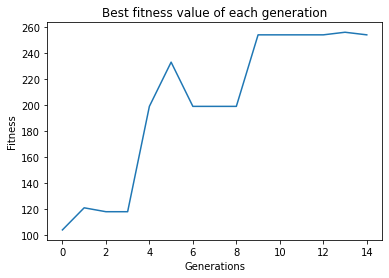

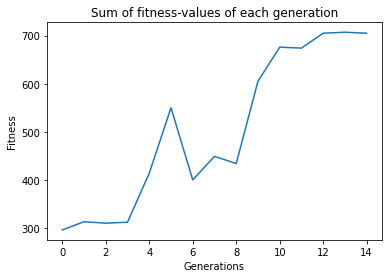

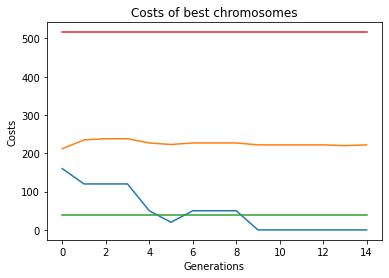

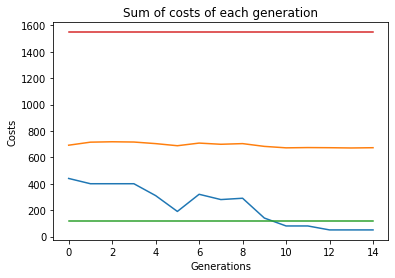

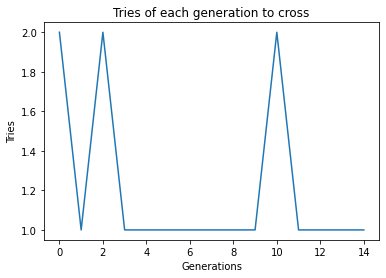

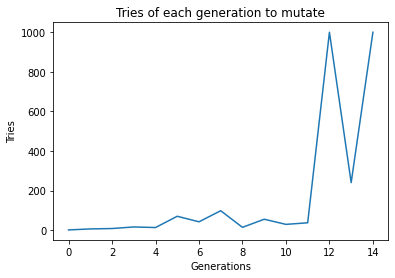

In [ ]:
single_plot()

# 10. Mehrfache Ausführung

## Beispiel

Die Variable `number_iterations` speichert die Anzahl an Iterationen. Bevor das Beispiel ausgeführt werden kann, muss die Variable in Kapitel 2 angepasst werden und der Code zur Initialisierung erneut ausgeführt werden. Im Anschluss ist die Ausführung des Beispiels möglich.

In [ ]:
np.random.seed(seed_number)
example_population = random_population()
start_time = time.time()
main_part(number_generations, example_population, False)
end_time = time.time()
print("The algorithm takes", "{:.2f}".format(end_time - start_time), "seconds for process")

Iteration: 0 Generation: 0
Population before generation:
 [[28.  6. 11. 12.]
 [10. 28. 13.  2.]
 [23.  9. 13.  9.]]
Fitness before generation:
 [0. 0. 3.]
Find interval of 2
Parents:
 [[23.  9. 13.  9.]
 [23.  9. 13.  9.]]
Crossover and tries to cross:
 [[23.  9. 13.  9.]] [1.]
tries 1.0
Mutation and tries to mutate:
 [[23.  9.  5.  9.]] [1.]
Population after generation:
 [[23.  9. 13.  9.]
 [23.  9. 13.  9.]
 [23.  9.  5.  9.]]
Fitness after generation:
 [  3.   3. 195.]
Iteration: 0 Generation: 1
Population before generation:
 [[23.  9. 13.  9.]
 [23.  9. 13.  9.]
 [23.  9.  5.  9.]]
Fitness before generation:
 [  3.   3. 195.]
Find interval of 80
Find interval of 1
Parents:
 [[23.  9.  5.  9.]
 [23.  9. 13.  9.]]
Crossover and tries to cross:
 [[23.  9.  5.  9.]] [1.]
tries 69.0
Mutation and tries to mutate:
 [[21.  9.  5.  9.]] [69.]
Population after generation:
 [[23.  9.  5.  9.]
 [23.  9. 13.  9.]
 [21.  9.  5.  9.]]
Fitness after generation:
 [195.   3. 267.]
Iteration: 0 Gener

## Plot

### Funktion

Die Funktion `multiple_plot()` zeigt Diagramme an, die relevante sind bei der Ausführung mehrerer Iterationen.

In [ ]:
def multiple_plot():
    plot(np.true_divide(population_fitness_after_sum.sum(axis=0), number_iterations), "Sum of fitness of each generation - average", "Generations", "Fitness")
    plot(np.true_divide(best_fitness_after.sum(axis=0), number_iterations), "Best fitness value of each generation - average", "Generations", "Fitness")
    costs_sum_average = np.zeros((number_generations, 4))
    costs_best_average = np.zeros((number_generations, 4))
    for i in range(number_iterations):
        for g in range(number_generations):
            costs_sum_average[g] += costs_sum_list[i][g]
            costs_best_average[g] += costs_max_list[i][g]
    plot(np.true_divide(costs_sum_average, number_iterations), "Sum of costs of each generation - average", "Generations", "Costs")
    plot(np.true_divide(costs_best_average, number_iterations), "Costs of best chromosomes - average", "Generations", "Costs")

    fig, ax1 = plt.subplots()
    ax1.boxplot(best_chromosome_of_iteration)
    ax1.set_title = "Best chromosomes of each iteration"
    ax1.set_xlabel('Gen of chromosome')
    ax1.set_ylabel('Value of gen')
    plt.show()

### Beispiel

Der folgende Abschnitt zeigt die Daten des vorherigen Beispiels an. Das erste Diagramm beschreibt den durchschnittlichen Verlauf der Summe der Fitness-Werte der Generationen. Die zweite Grafik zeigt die durchschnittliche Fitness der besten Chromosome jeder Generation. Danach folgen die durchschnittlichen Kosten jeder Generation und der besten Chromosome. Die letzte Grafik zeigt die Verteilungen der besten Chromosome jeder Iteration an.

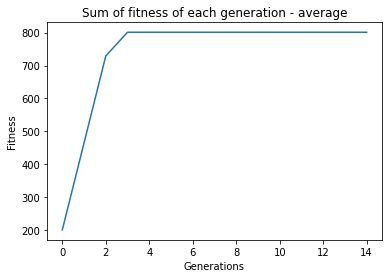

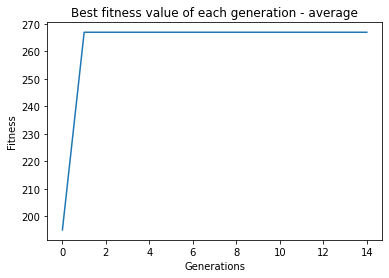

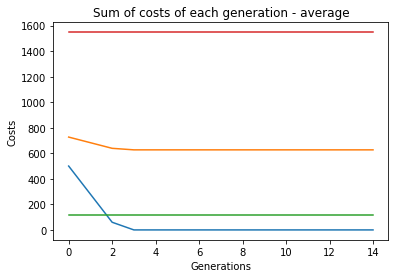

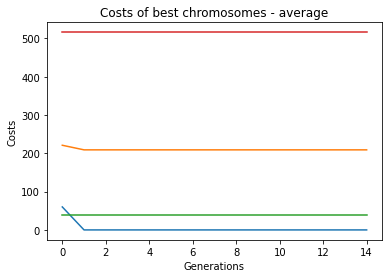

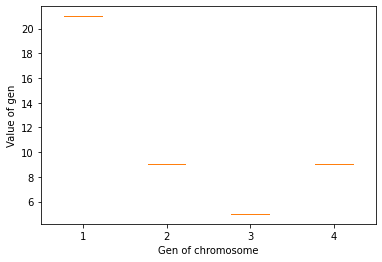

In [ ]:
multiple_plot()

# 11. Skalierung

## 11.1 Beispiel

Der Algorithmus kann unterschiedliche Anzahlen an Lieferanten und Produkten verarbeiten. Das folgende Beispiel beschreibt den Fall, dass drei Lieferanten vier Produkte anbieten. Zusätzlich besteht die Population aus vier Chromosomen.

In [ ]:
seed_number = 1
np.random.seed(seed_number)
selling_price = np.array([13, 9, 12, 17])
supplier_price = np.array([[6, 4, 5, 9], [4, 3, 4, 13], [7, 5, 4, 10]])
transaction_cost = np.array([10, 30, 40])
holding_cost = np.array([30, 20, 15, 12])
demands = np.array([30, 14, 7, 10])
number_products = len(selling_price)
number_suppliers = len(supplier_price)
population_size = 4
lower_bound = 0
upper_bound = np.array([50, 34, 27, 30])
number_iterations = 2
number_generations = 15
penalty = 99999

chromosome_size = number_suppliers * number_products
init_population = np.zeros((population_size, chromosome_size))
number_parents = (population_size // 2) + (population_size % 2)
number_children = (population_size - number_parents)

population_before = np.zeros((number_iterations, number_generations, population_size, chromosome_size))
population_fitness_before = np.zeros((number_iterations, number_generations, population_size))
population_after = np.zeros((number_iterations, number_generations, population_size, chromosome_size))
population_fitness_after = np.zeros((number_iterations, number_generations, population_size))
population_fitness_after_sum = np.zeros((number_iterations, number_generations))
best_chromosomes_after = np.zeros((number_iterations, number_generations, chromosome_size))
best_fitness_after = np.zeros((number_iterations, number_generations))
best_chromosome_of_iteration = np.zeros((number_iterations, chromosome_size))
best_fitness_of_iteration = np.zeros(number_iterations)

parents_list = np.zeros((number_iterations, number_generations, number_parents, chromosome_size))
crossover_list = np.zeros((number_iterations, number_generations, number_children, chromosome_size))
tries_crossover_list = np.zeros((number_iterations, number_generations, number_children))
mutation_list = np.zeros((number_iterations, number_generations, number_children, chromosome_size))
tries_mutation_list = np.zeros((number_iterations, number_generations, number_children))

costs_list = np.zeros((number_iterations, number_generations, population_size, 4))
costs_max_list = np.zeros((number_iterations, number_generations, 4))
costs_sum_list = np.zeros((number_iterations, number_generations, 4))

### 11.1.1 Population

Die Erhöhung der Lieferantenanzahl und Produktanzahl erschwert den Prozess der Generierung einer zufälligen Population. Der Algorithmus muss mehr Gene bestimmen, welche zu einem positiven Fitness-Wert führen. Im Szenario mit drei Lieferanten und vier Produkten sind es 12 Gene. Die Implementierung zur Erzeugung einer Ausgangspopulation endet mit einer Population, in der mindestens ein Chromosom mit positivem Fitness-Wert existiert. Dadurch entsteht in diesem Szenario meist eine Population mit nur einem positiven Chromosom, welches sich kreuzt, sodass die Lösungen am Ende kaum vom Anfang unterscheiden. Von 100 generierten Populationen haben lediglich 6 mehr als 1 Chromosom mit positiver Fitness. Dies verfehlt die Idee eines genetischen Algorithmus.

In [ ]:
seed_number = 1
number_positive_chroms = 0  # Anzahl an positiven Chromosomen
number_negative_chroms = 0  # Anzahl an negativen Chromosomen
for counter in range(100):  # Prüfen von Populationen
    np.random.seed(counter)
    example_population = random_population()  # Population erzeugen
    fitness_sum = 0
    for chrom in example_population:  # Summe der Fitness-Werte der Chromosome berechnen
        fitness_sum += calculate_fitness(chrom)
    while fitness_sum <= 0:  #  Neue Population erzeugen, solange kein positives Chromosom vorhanden ist
        fitness_sum = 0
        example_population = random_population()
        for chrom in example_population:
            fitness_sum += calculate_fitness(chrom)
    print("Population:", counter)
    for chrom in example_population:  
        fit = calculate_fitness(chrom)
        if fit == 0:  # Prüfen, wie viele Chromosome positiv/negativ sind
            number_negative_chroms += 1
        else:
            number_positive_chroms += 1
        print("Chromosom:", chrom, "Fitness:", calculate_fitness(chrom))  # Chromosome mit deren Fitness ausgeben
print(number_positive_chroms, "chromosomes have an positive fitness value.", number_negative_chroms, "chromosomes have an negative fitness value.")


Population: 0
Chromosom: [28. 27. 15.  3.  3. 12.  3.  4.  4.  7.  8.  4.] Fitness: 0
Chromosom: [ 3.  2. 25.  8. 12.  1.  4.  4.  2.  0.  8.  3.] Fitness: 41.0
Chromosom: [ 9. 21.  5.  1.  7. 13.  6.  0.  6.  4.  7.  3.] Fitness: 0
Chromosom: [21. 27. 12.  5. 11. 11.  6.  1.  3.  7.  5.  5.] Fitness: 0
Population: 1
Chromosom: [25. 16. 28.  2.  0. 13.  2.  4.  1.  7.  9.  8.] Fitness: 0
Chromosom: [10. 28. 20. 12.  9.  8.  2.  4.  4.  7.  2.  6.] Fitness: 0
Chromosom: [22.  6.  2.  7.  7.  0.  6.  5.  1.  4.  6.  0.] Fitness: 228.0
Chromosom: [22.  5. 13.  5.  4. 10.  1.  6.  5.  4.  4.  6.] Fitness: 0
Population: 2
Chromosom: [ 9. 14. 28. 11.  0. 10.  6.  2.  0.  2.  9.  6.] Fitness: 0
Chromosom: [ 5.  6. 22.  6.  3.  8.  2.  1.  4.  8.  1.  6.] Fitness: 24.0
Chromosom: [25. 29.  5. 10.  7.  6.  3.  4.  5.  8.  3.  0.] Fitness: 0
Chromosom: [16. 21. 23. 11.  5. 11.  6.  2.  5.  1.  7.  4.] Fitness: 0
Population: 3
Chromosom: [ 0. 18. 13.  6. 12.  0.  3.  0.  4.  8.  3.  3.] Fitness: 

### 11.1.2 Laufzeit

Wa ist mit einem Anstieg der Laufzeit zu rechnen. Das Beispiel aus Kapitel 9 mit zwei Produkten, zwei Lieferanten und einer Population mit drei Chromosomen benötigt 0,3 Sekunden für eine Iteration. Dieses Beispiel benötigt über 2 Sekunden, sodass eine Erweiterung um mehr Lieferanten und Produkten zu längeren Laufzeiten führt.

In [ ]:
np.random.seed(seed_number)
start_time = time.time()
example_population = random_population()
main_part(number_generations, example_population, False)
end_time = time.time()
print("The algorithm takes", "{:.2f}".format(end_time - start_time), "seconds for process")

if number_iterations >= 2:
    print("The chromosome", best_chromosome_of_iteration[np.argmax(best_fitness_of_iteration)],
          "has the maximum fitness of", np.amax(best_fitness_of_iteration))
else:
    print("The chromosome", best_chromosome_of_iteration, "has the maximum fitness of", best_fitness_of_iteration)

Iteration: 0 Generation: 0
All fitnesses are negative. Change start population
All fitnesses are negative. Change start population
All fitnesses are negative. Change start population
All fitnesses are negative. Change start population
All fitnesses are negative. Change start population
All fitnesses are negative. Change start population
All fitnesses are negative. Change start population
All fitnesses are negative. Change start population
All fitnesses are negative. Change start population
Population before generation:
 [[28. 27. 15.  3.  3. 12.  3.  4.  4.  7.  8.  4.]
 [ 3.  2. 25.  8. 12.  1.  4.  4.  2.  0.  8.  3.]
 [ 9. 21.  5.  1.  7. 13.  6.  0.  6.  4.  7.  3.]
 [21. 27. 12.  5. 11. 11.  6.  1.  3.  7.  5.  5.]]
Fitness before generation:
 [ 0. 41.  0.  0.]
Find interval of 29
Parents:
 [[ 3.  2. 25.  8. 12.  1.  4.  4.  2.  0.  8.  3.]
 [ 3.  2. 25.  8. 12.  1.  4.  4.  2.  0.  8.  3.]]
Crossover and tries to cross:
 [[ 3.  2. 25.  8. 12.  1.  4.  4.  2.  0.  8.  3.]
 [ 3.  2